<a href="https://colab.research.google.com/github/melodyyu1112/Machine_learning_416/blob/master/A3_Sentiment_Analysis_with_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Predicting Sentiment from Product Reviews

### Due: Tuesday, July 16th, 11:59 pm on Gradescope.

Use product review data from amazon.com to predict whether the sentiments about a product are positive or negative. In this assignment, you will practice:

* Use Pandas Dataframes to do feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given a classifier, create a confusion matrix
* Compare multiple logistic regression models.


> Copyright ©2019 Emily Fox and Hunter Schafer.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Summer Quarter 2019 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---

In [0]:
!pip install -q seaborn==0.9.0

In [0]:
# Only run this cell if you are running on colab
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)
    
save_file('https://homes.cs.washington.edu/~hschafer/cse416/a3/products.csv', 'products.csv')
save_file('https://homes.cs.washington.edu/~hschafer/cse416/a3/important_words.json', 'important_words.json')

In [0]:
# import general python libraries
import math
import string

# import basic datascience libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn specific imports 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Hide some auxiliary warnings
import warnings
warnings.filterwarnings('ignore')

# enable plotting inline
%matplotlib inline

# Data preperation

We will use a dataset consisting of baby product reviews on Amazon.com.

In [0]:
products = pd.read_csv('products.csv')
products = products.iloc[200:700]
products.head()

,name,review,rating
200,"Summer Infant Ultimate Crib Sheet, 52&quot; x ...",I received 2 of these sheets as a gift after m...,5
201,"Summer Infant Ultimate Crib Sheet, 52&quot; x ...",This item posses a chocking hazzard. I woke up...,1
202,Basic Comfort Handy's Plus Pad Full,I was looking for a nightime waterproof pad fo...,5
203,"Summer Infant, Ultimate Training Pad - Twin Ma...",Great Product ... Highly Recommend! No more ch...,5
204,"Summer Infant, Ultimate Training Pad - Twin Ma...","It does the job of protecting the mattress, th...",4


## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [0]:
products = products[products['rating'] != 3]
len(products)

500

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [0]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products.head()

,name,review,rating,sentiment
200,"Summer Infant Ultimate Crib Sheet, 52&quot; x ...",I received 2 of these sheets as a gift after m...,5,1
201,"Summer Infant Ultimate Crib Sheet, 52&quot; x ...",This item posses a chocking hazzard. I woke up...,1,-1
202,Basic Comfort Handy's Plus Pad Full,I was looking for a nightime waterproof pad fo...,5,1
203,"Summer Infant, Ultimate Training Pad - Twin Ma...",Great Product ... Highly Recommend! No more ch...,5,1
204,"Summer Infant, Ultimate Training Pad - Twin Ma...","It does the job of protecting the mattress, th...",4,1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Clean the data

Let us explore a specific example of a baby product.

In [0]:
products.iloc[21]

name                        Odorless Diaper Pail by Safety 1st
review       I've found that the Odor-Less Diaper Pail is n...
rating                                                       1
sentiment                                                   -1
Name: 221, dtype: object

Perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. Remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](ftp://ftp.cis.upenn.edu/pub/treebank/public_html/tokenization.html) for an example of smart handling of punctuations.

In [0]:
def remove_punctuation(text):
    """
    Given a string, returns a new string without any punctuation.
    
    If the value is not a string, returns the empty string.
    """
    if type(text) != str:
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

products['review_clean'] = products['review'].apply(remove_punctuation)

Explore what the sample example above looks like after these 2 transformations.

In [0]:
print(products['review'].iloc[1])
print()
print(products['review_clean'].iloc[1])

This item posses a chocking hazzard. I woke up to my 6 month old gagging on the elastic strap that holds the sheet to the crib. While it may seem like a wonderful invention (oh how i miss it!) I don't think it's worth the risk.

This item posses a chocking hazzard I woke up to my 6 month old gagging on the elastic strap that holds the sheet to the crib While it may seem like a wonderful invention oh how i miss it I dont think its worth the risk


## Build the word count vector for each review
Next we need to count up the number of times each word appears in each review. We start by making a list of dictionaries, where each entry in the list is a dictionary mapping the words in that review to the number of times that word appears in that review

In [0]:
word_count = []

for i in range(0,len(products)):
    word_count_dict = {}
    review_clean = products['review_clean'].iloc[i]
    review_clean = review_clean.split(' ')
    for word in review_clean:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
    word_count.append(word_count_dict)

# Add these dictionaries as a word_count feature
products['word_count'] = word_count

This dictionary approach is nice for us to work with, by `sklearn` needs the data to be a vector. We use `DictVectorizer` from `sklearn` to take this dictionary and turn it into a high-dimensional vector. 

In [0]:
# Create a DictVectorizer and create vectors for these dictionaries
dict_vectorizer = DictVectorizer()
feature_vectors = dict_vectorizer.fit_transform(products['word_count'])
# Create a new DataFrame that has all these features as columns plus the sentiment label!
product_data = pd.DataFrame(feature_vectors.toarray())
product_data['sentiment'] = list(products['sentiment'])
product_data['review_clean'] = list(products['review_clean'])  # to display later
product_data['name'] = list(products['name'])  # to display later
product_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5051,5052,5053,5054,5055,5056,5057,5058,5059,5060,5061,5062,5063,5064,5065,5066,5067,5068,5069,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,sentiment,review_clean,name
0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,I received 2 of these sheets as a gift after m...,"Summer Infant Ultimate Crib Sheet, 52&quot; x ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,This item posses a chocking hazzard I woke up ...,"Summer Infant Ultimate Crib Sheet, 52&quot; x ..."
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,I was looking for a nightime waterproof pad fo...,Basic Comfort Handy's Plus Pad Full
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Great Product Highly Recommend No more changi...,"Summer Infant, Ultimate Training Pad - Twin Ma..."
4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,It does the job of protecting the mattress the...,"Summer Infant, Ultimate Training Pad - Twin Ma..."


## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `random_state = 1` so that everyone gets the same result.

In [0]:
train_data, test_data = train_test_split(product_data, test_size = 0.2, random_state = 1)
print (len(train_data))
print (len(test_data))

400
100


## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. Given a classification problem with 2 classes, the majority class classifier has at least 50% accuracy. 


<div class="alert alert-block alert-success">
    <h4>Question 1</h4> 
    <p>
        Compute the majority class on the training set and use that to figure out what the majority class classifiers <b>test accuracy</b> will be.</p>
<ul>
  <li> 0.63 (63%)
  </ul>
</div>

*Hint:* pandas takes the sum of a boolean Series - true values are equal to 1, false values are equal 0.

In [0]:
# TODO 
num_positive  = (train_data['sentiment'] == +1).sum()
num_negative = (train_data['sentiment'] == -1).sum()
print(num_positive)
print(num_negative)
print(num_positive/len(train_data))
test_num_positive  = (test_data['sentiment'] == +1).sum()
test_num_negative = (test_data['sentiment'] == -1).sum()
print(test_num_positive)
print(test_num_negative)
print(test_num_positive/len(test_data))
print(test_num_negative/len(test_data))


154
246
0.385
37
63
0.37
0.63


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use all of the features generated earlier and the column **sentiment** as the target; notice we remove `'sentiment'`, `'review_clean'`, and `'name'` from the list of features since we don't want to use those.  We will **no regularization penalty** by setting $\lambda$ to a very small value and set `random_state = 1` so that everyone gets the same answer. 

`sklearn.LogisticRegression` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) uses a value named `c` for the regularization hyper-parameter where $c = \frac{1}{\lambda}$. This means a really large value of `c` corresponds to a very small $\lambda$.

*Note:* This line can take up to a few minutes to run.

In [0]:
features = list(train_data.columns)
features.remove('sentiment')
features.remove('review_clean')
features.remove('name')
print(features)

#Note: C = 1/Lambda. Setting C to a really high value is the same as setting lambda = 0
sentiment_model = LogisticRegression(penalty='l2', random_state=1, C=1e23)
sentiment_model.fit(train_data[features], train_data['sentiment'])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

LogisticRegression(C=1e+23, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
weights = sentiment_model.coef_[0]  # LogisticRegression returns a 2-d array so we grab the one row
weights


array([ 0.17201422, -0.22388844, -0.08125083, ...,  0.        ,
        0.        ,  0.28335441])

<div class="alert alert-block alert-success">
    <h4>Question 2</h4> 
    <p>
        Compute the number of <i>weights</i> are non-negative (>= 0).
    </p>
    <ul>
      <li> 2783
      </ul>
</div>

In [0]:
# TODO 
print(sum(weights>=0))


2783


## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **test data**. In this section, we will explore this in the context of 3 examples in the test dataset.  We refer to this set of 3 examples as the **sample_test_data**.

In [0]:
sample_test_data = test_data[12:15]
sample_test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5051,5052,5053,5054,5055,5056,5057,5058,5059,5060,5061,5062,5063,5064,5065,5066,5067,5068,5069,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,sentiment,review_clean,name
119,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,This tub is very hard to set up and I had to t...,Safety 1st Deluxe 4-in-1 Bath Station
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,I have a 2 year old that ended up walking down...,Secure Grip Door Knob Covers
305,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Purchased this for my Grandson to use at my ho...,"Sesame Street Potty Soft Seat, Elmo"


### Predicting sentiment
We first show the predicted probabilities for belonging to each class. We then show the actual predictions `sample_test_data`.

In [0]:
print ("Probability predictions on the sample test data:")
print('Negative Sentiment  Positive Sentiment')
print(sentiment_model.predict_proba(sample_test_data[features]))
print(sentiment_model)

Probability predictions on the sample test data:
Negative Sentiment  Positive Sentiment
[[1.00000000e+00 2.43424513e-23]
 [7.52295709e-03 9.92477043e-01]
 [1.49294092e-03 9.98507059e-01]]
LogisticRegression(C=1e+23, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [0]:
print(sentiment_model.predict(sample_test_data[features]))

[-1  1  1]


# Find the most positive review and most negative review

We now turn to examining the full test dataset **test_data** <span style="color:red">(not sample_test_data)</span> and use the `LogisticRegression` model to make predictions on the points.

Using the `sentiment_model`, find the **first** review in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to this as the "most positive review." Also do this for the "most negative review" (the first review with the highest probability being classified as a negative review). Make sure you print out your results so we know you wrote the code correctly!

*Hint:* Once you know the index of the most positive/negative reviews, use the `.iloc[]` accessor on the DataFrame to get that row and find its name.

In [0]:
# TODO 
df=sentiment_model.predict_proba(test_data[features])
dataset = pd.DataFrame({'Negative':df[:,0],'Positive':df[:,1]})
maxValueIndexObj = dataset.idxmax()
neg = maxValueIndexObj[0]
pos = maxValueIndexObj[1]

negative_row = test_data.iloc[neg]
most_negative = negative_row["name"]

positive_row = test_data.iloc[pos]
most_positive = positive_row["name"]

print(most_negative)
print(most_positive)






Safety 1st Deluxe 4-in-1 Bath Station
Graco TotBloc Pack 'N Play with Carry Bag, Bugs Quilt


<div class="alert alert-block alert-success">
    <h4>Question 3</h4> 
    <p>
        Using the sentiment model with test_data, which product has the most positive reivew?
    </p>
    <ul>
        <li>Graco TotBloc Pack 'N Play</li>

</div>


<div class="alert alert-block alert-success">
    <h4>Question 4</h4> 
    <p>
        Using the sentiment model with test_data, which product has the most negative review?
    </p>
    <ul>
        <li>Safety 1st Deluxe 4-in-1 Bath Station</li>

    </ul>
</div>


---
# Create a confusion matrix

A common tool that helps assess classification models is the confusion matrix.

We've created a function that will plot a confusion matrix for you given a set of inputs which are the values that should appear within each cell.
Recall that there are four values associated with a confusion matrix: true positive, true negative, false positive, and false negative which we will abberviate as TP, TN, FP, and FN, respecitvely. 

In [0]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])
    
    sns.heatmap(data, annot=True, cmap='YlGnBu',
                xticklabels=['Actual Pos.', 'Actual Neg.'], 
                yticklabels=['Pred. Pos.', 'Pred. Neg.'])

Write code below that uses the `plot_confusion_matrix` function to show the number of true positive, true negative, false positive, and false negative predictions made by your classifier on the test data.

You might find it useful to use named parameters here (i.e. you can call `plot_confusion_matrix(tp=X, fp=Y, fn=A, tn=B)` instead of having to get the order of tha parameters correct.)

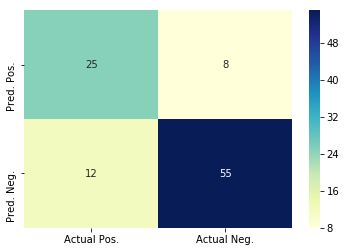

In [0]:
# TODO 
y_true = test_data['sentiment']
y_pred = sentiment_model.predict(test_data[features])
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
plot_confusion_matrix(tp, fp, fn, tn)

<div class="alert alert-block alert-success">
    <h4>Question 5</h4> 
    <p>
        Reading the plot above, how many products in the test set are classified as having negative sentiment that should be classified as having a positive sentiment?
    </p>
<ul>
  <li> 12
  </ul>
</div>

---
# Calculating Accuracy

Now that we have succesfully trained a model, let's compare the accuracy of the `sentiment_model` to that of the baseline majority class classifier. Below, calculate the accuracy of each model using sklearn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function.

<div class="alert alert-block alert-success">
    <h4>Question 6</h4> 
    <p>
        Based on their respective accuracies, which model would we expect to perform better on unseen data?
    </p>
    <p>
      <ul>
            <li>sentiment_model</li>
    </ul>
</div>

In [0]:
# TODO 
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)


0.8

---
# Logistic Regression with L2 regularization

We compiled a list of 193 most frequent words into the JSON file named `important_words.json`. Load the words into a list important_words. We're going to load them in and create column with the count for each of the words. We're doing this so that we can observe the effect of L2 regularization on the features.

In [0]:
# Split out the words into individual columns
import json

with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

important_words[0:10]

['baby',
 'one',
 'great',
 'love',
 'use',
 'would',
 'like',
 'easy',
 'little',
 'seat']

We then create new features for each review by finding the count of each of the important words

In [0]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))
products.head()

,name,review,rating,sentiment,review_clean,word_count,baby,one,great,love,use,would,like,easy,little,seat,old,well,get,also,really,son,time,bought,product,good,daughter,much,loves,stroller,put,months,car,still,back,used,recommend,first,even,perfect,...,looks,second,piece,box,pretty,trying,difficult,together,though,give,started,anything,last,company,come,returned,maybe,took,broke,makes,stay,instead,idea,head,said,less,went,working,high,unit,seems,picture,completely,wish,buying,babies,won,tub,almost,either
200,"Summer Infant Ultimate Crib Sheet, 52&quot; x ...",I received 2 of these sheets as a gift after m...,5,1,I received 2 of these sheets as a gift after m...,"{'I': 5, 'received': 1, '2': 2, 'of': 2, 'thes...",0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
201,"Summer Infant Ultimate Crib Sheet, 52&quot; x ...",This item posses a chocking hazzard. I woke up...,1,-1,This item posses a chocking hazzard I woke up ...,"{'This': 1, 'item': 1, 'posses': 1, 'a': 2, 'c...",0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
202,Basic Comfort Handy's Plus Pad Full,I was looking for a nightime waterproof pad fo...,5,1,I was looking for a nightime waterproof pad fo...,"{'I': 2, 'was': 1, 'looking': 2, 'for': 2, 'a'...",0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
203,"Summer Infant, Ultimate Training Pad - Twin Ma...",Great Product ... Highly Recommend! No more ch...,5,1,Great Product Highly Recommend No more changi...,"{'Great': 1, 'Product': 1, '': 1, 'Highly': 1,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
204,"Summer Infant, Ultimate Training Pad - Twin Ma...","It does the job of protecting the mattress, th...",4,1,It does the job of protecting the mattress the...,"{'It': 1, 'does': 1, 'the': 10, 'job': 1, 'of'...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now that we have written up all the pieces needed for regularized logistic regression, let's explore the affects of using **L2 regularization** in analyzing sentiment for product reviews. Below, write code to train models with increasing amounts of regularization, starting with a small L2 penalty. We have provided some starter code to set up the data structures, but you will write the code to train the model. Here are the implementation details:

* Train a model with the `important_words` as features for each of the `l2_penalties` to predict the target `sentiment`. Add a column to `table` with the respective `column_name` to save the coefficients for that model. You should use the entire products dataset here since we will not be using these models in the future and don't need a good estimate of future performance.
* When creating the model, make sure to pass `random_state=1`. You should pass no other parameters to the model besides the L2 penalty.
* The coefficients will be a row vector, but to store it in the `DataFrame`, you need it to be a column. To do this, use `.T` on the coefficients to transpose them to a column vector.
* You should end up with an DataFrame with column names as `'coefficients [L2=1]', ... 'coefficients [L2=1e5]'`, and a row for each word in `important_words`.
* <span style="color:red">Note: when constructing the LogisticRegression(...) model, the parameter `C` is the **inverse** of the L2 penalty (1 / L2_penalty). </span>

In [0]:
# TODO: Fill in the loop
l2_penalties = [1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = ['coefficients [L2=1]', 'coefficients [L2=4]', 'coefficients [L2=10]', 
                    'coefficients [L2=1e2]', 'coefficients [L2=1e3]', 'coefficients [L2=1e5]']



# Add the coefficients to this table for each model
table = pd.DataFrame(columns = ['word'] + l2_penalty_names)
table['word'] = important_words

for l2_penalty, column_name in zip(l2_penalties, l2_penalty_names):
  #TODO: Train the model and save the coefficients
  for i in range(6):
    sentiment_model2 = LogisticRegression(penalty='l2', random_state=1, C=1/l2_penalties[i])
    sentiment_model2.fit(products[important_words], products['sentiment'])
    weights = (sentiment_model2.coef_[0]).T
    table[l2_penalty_names[i]] = weights
                   
table.head()

,word,coefficients [L2=1],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,baby,-0.055431,-0.022926,-0.016751,-0.039849,-0.021073,-0.000362
1,one,0.309416,0.231770,0.181135,0.046312,-0.004395,-0.000173
2,great,0.535860,0.368856,0.282650,0.080335,0.005783,0.000006
3,love,1.370229,0.854513,0.592120,0.137861,0.015086,0.000135
4,use,0.171536,0.086429,0.055540,0.002273,-0.009710,-0.000203


## Look at the Coefficients
Using **the coefficients trained with L2 penalty 1**, find the 5 most positive words (with largest positive coefficients) and save them in a variable named  `positive_words`. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to a variable named `negative_words`.

*Hint:* You can use the `.nlargest()`and `.nsmallest()` method on an DataFrame to find the top k rows sorted according to the value of a specified column. See [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nlargest.html) and [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nsmallest.html#pandas.DataFrame.nsmallest) for more info.

<div class="alert alert-block alert-success">
    <h4>Question 7</h4> 
    <p>
        Which of the following appears in neither positive_words nor negative_words
    </p>
  </ul>
        <li>bad</li>
    </ul>
</div>


In [0]:
# TODO
positive_table = table.nlargest(5, 'coefficients [L2=1]')
positive_words = positive_table['word']
negative_table = table.nsmallest(5, 'coefficients [L2=1]')
negative_words = negative_table['word']


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [0]:
def plot_words(ax, xx, data, words, cmap):
    for i in range(len(data)):
        # Change the color scale to be from 0.2-0.8 instead of 0-1
        color = cmap(0.6 * (i / len(data)) + 0.2) 
        ax.plot(xx, list(data.iloc[i]),
                '-', label=words.iloc[i], linewidth=4.0, color=color)
        
def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list, l2_penalty_names):
    # Get colormaps for plotting
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    # Create canvas for plotting
    fig, ax = plt.subplots(1, figsize=(10,6))
    
    # Draw horizontal -- line at 0
    xx = l2_penalty_list
    ax.plot(xx, [0.] * len(xx), '--', lw=1, color='k')
    
    # Separate data into positive and negative words
    table_positive_words = table[table['word'].isin(positive_words)][l2_penalty_names]
    table_negative_words = table[table['word'].isin(negative_words)][l2_penalty_names]
    
    # Plot each positive and negative word
    plot_words(ax, xx, table_positive_words, positive_words, cmap_positive)
    plot_words(ax, xx, table_negative_words, negative_words, cmap_negative)
        
    # Change a bunch of other chart properties
    ax.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    ax.axis([1, 1e5, -2, 2])
    ax.set_title('Coefficient path')
    ax.set_xlabel('L2 penalty ($\lambda$)')
    ax.set_ylabel('Coefficient value')
    ax.set_xscale('log')
    fig.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

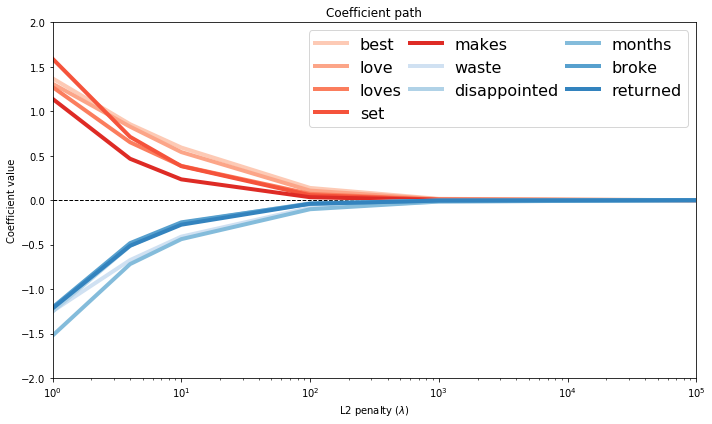

In [0]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=l2_penalties, l2_penalty_names=l2_penalty_names)

<div class="alert alert-block alert-success">
    <h4>Question 8</h4> 
    <p>
        Overall, all coefficients generally get smaller in size as the L2 penalty is increased.
    </p>
    <ul>
      <li> True
      </ul>
</div>